<a href="https://colab.research.google.com/github/vinifm/42_basecamp/blob/main/src/models/bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Referências
- [Análise de sentimentos em português utilizando Pytorch e Python](https://medium.com/data-hackers/an%C3%A1lise-de-sentimentos-em-portugu%C3%AAs-utilizando-pytorch-e-python-91a232165ec0)
- [Ceweb.br - Bert_HateSpeech_Classification](https://github.com/cewebbr/Bert_HateSpeech_Classification)

# Pre-processing

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Tell pytorch to use GPU, if available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


Select only the text and hate speech flag.

In [5]:
dataset_path = '/content/2019-05-28_portuguese_hate_speech_binary_classification.csv'
df = pd.read_csv(dataset_path)
df = df[['text', 'hatespeech_comb']]
df.head()

,text,hatespeech_comb
0,@__andrea__b \nO cara vive em outro mundo\nNão...,1
1,@_carmeloneto Estes incompetentes não cuidam n...,0
2,@_carmeloneto \nOs 'cumpanhero' quebraram toda...,0
3,@_GlitteryKisses é isso não conseguem pensar n...,0
4,@_iglira bom dia macaco branco haha,1


## Tokenization

In [6]:
import torch.nn as nn
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import numpy as np
from sklearn.model_selection import train_test_split

We used the pretrained model [neuralmind/bert-base-portuguese-cased](https://huggingface.co/neuralmind/bert-base-portuguese-cased) from Hugging Face

In [7]:
PRE_TRAINED_MODEL_NAME = 'neuralmind/bert-base-portuguese-cased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/43.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/210k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/647 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [8]:
sample_txt = df['text'][1]
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: @_carmeloneto Estes incompetentes não cuidam nem do povo brasileiro e nem dos poucos refugiados que aqui estão.
   Tokens: ['@', '_', 'car', '##melo', '##neto', 'Estes', 'incomp', '##et', '##entes', 'não', 'cuida', '##m', 'nem', 'do', 'povo', 'brasileiro', 'e', 'nem', 'dos', 'poucos', 'refugiados', 'que', 'aqui', 'estão', '.']
Token IDs: [137, 168, 505, 13877, 12915, 4218, 14644, 735, 639, 346, 18545, 22287, 2798, 171, 2049, 1910, 122, 2798, 298, 3885, 14598, 179, 5863, 1376, 119]


In [9]:
MAX_LEN = 125
RANDOM_SEED = 42

In [10]:
class HateSpeechDataset(Dataset):

  def __init__(self, text, targets, tokenizer, max_len):
    self.text = text
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.text)

  def __getitem__(self, item):
    text = str(self.text[item])
    target = self.targets[item]

    encoding = tokenizer.encode_plus(
      sample_txt,
      max_length=MAX_LEN,
      add_special_tokens=True, # Add '[CLS]' and '[SEP]'
      return_token_type_ids=False,
      padding='longest',
      return_attention_mask=True,
      return_tensors='pt',  # Return PyTorch tensors
      truncation=True
    )

    return {
      'text': text,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [11]:
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
df_train, df_test = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [12]:
df_train.shape, df_val.shape, df_test.shape

((5103, 2), (283, 2), (284, 2))

In [13]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = HateSpeechDataset(
    text=df.text.to_numpy(),
    targets=df.hatespeech_comb.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=2
  )

In [14]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


# Classifier

In [15]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict=False)
    self.drop = nn.Dropout(p=0.3)
    #The last_hidden_state is a sequence of hidden states of the last layer of the model
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [16]:
model = SentimentClassifier(n_classes=2)
model = model.to(device)

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

# Training

In [17]:
EPOCHS = 10

optimizer = torch.optim.AdamW(model.parameters(), lr=3e-5)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [18]:
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0

  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [21]:
%%time

from collections import defaultdict

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/10
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train loss 0.6444880965641674 accuracy 0.6766607877718989
Val   loss 0.6076387067635854 accuracy 0.7067137809187279

Epoch 2/10
----------
Train loss 0.6381881238898514 accuracy 0.6796002351557907
Val   loss 0.6081895149416394 accuracy 0.7067137809187279

Epoch 3/10
----------
Train loss 0.635123981297203 accuracy 0.6813639035861259
Val   loss 0.608985518415769 accuracy 0.7067137809187279

Epoch 4/10
----------
Train loss 0.6315686632660116 accuracy 0.6811679404271996
Val   loss 0.6083956609169642 accuracy 0.7067137809187279

Epoch 5/10
----------
Train loss 0.6326581481669017 accuracy 0.6803840877914952
Val   loss 0.60824882487456 accuracy 0.7067137809187279

Epoch 6/10
----------
Train loss 0.6321556559737573 accuracy 0.6811679404271996
Val   loss 0.6102740797731612 accuracy 0.7067137809187279

Epoch 7/10
----------
Train loss 0.6279762594677438 accuracy 0.6811679404271996
Val   loss 0.6113671594195895 accuracy 0.7067137809187279

Epoch 8/10
----------
Train loss 0.6298401765875682 a

# Evaluation

In [31]:
train_acc_list = [t.cpu().numpy() for t in history['train_acc']]
val_acc_list = [v.cpu().numpy() for v in history['val_acc']]

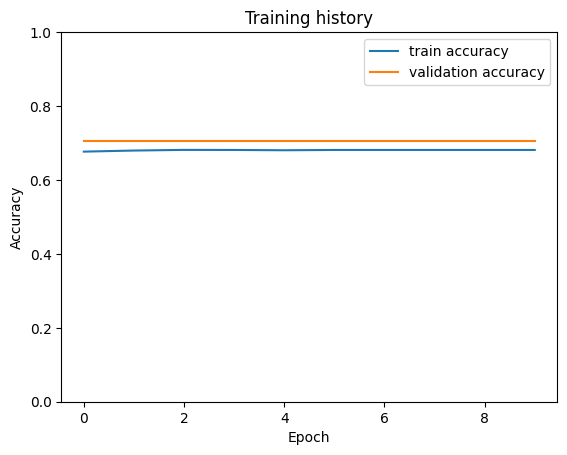

In [32]:
plt.plot(train_acc_list, label='train accuracy')
plt.plot(val_acc_list, label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [35]:
import torch.nn.functional as F

def get_predictions(model, data_loader):
  model = model.eval()
  texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return texts, predictions, prediction_probs, real_values

In [36]:
y_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

# To-dos
- Documentar no código:
    - [ ] Dataset e dataloader do pytorch

# Dúvidas
